In [28]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [4]:
#preprocessing
transform = transforms.Compose([transforms.ToTensor()])

In [10]:
batch_size = 4

In [7]:
training_dataset = torchvision.datasets.MNIST(root="Data", download=True, train=True, transform=transform)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [19]:
test_dataset = torchvision.datasets.MNIST(root='Data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [20]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [21]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [22]:
img, label = training_dataset[0]

In [25]:
img.shape

torch.Size([1, 28, 28])

In [26]:
label

5

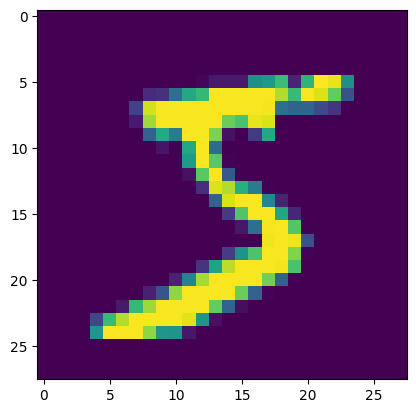

In [29]:
plt.imshow(img.reshape(28,28))

In [31]:
test_flatten = nn.Flatten()
test_flatten(img).size()

torch.Size([1, 784])

In [32]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logint = self.network(x)
        return logint


In [34]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cput"
device

'mps'

In [35]:
model =NN().to(device=device)

In [36]:
for parms in model.parameters():
    print(parms.numel())

100352
128
8192
64
640
10


In [37]:
for name, params in model.named_parameters():
    print(name)

network.0.weight
network.0.bias
network.2.weight
network.2.bias
network.4.weight
network.4.bias


In [39]:
784*128

100352

In [40]:
128*64

8192

In [41]:
64*10

640

In [42]:
10

10

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
EPOCH = 1
best_vloss = 1_000_00.
epoch_number=0

In [ ]:
for epoch in range(EPOCH):
    running_loss = 0
    lost_per_batch = 0

    model.train(True)

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        output = model(inputs.to(device=device))

        loss = loss_fn(output, labels.to(device=device))
        loss.backward()

        optimizer.step()

        running_loss = running_loss + loss.item()

        if i % 999:
            loss_per_batch = running_loss / 1000
            print(f"batch :{i} loss: {loss_per_batch}")
    
    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            running_loss+=vloss
    
    avg_vloss = running_loss / (i+1)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f"model_{epoch}"
        torch.save(model.state_dict(), model_path)
    
    epoch_number+=1

print("Training is completeds")


batch :1 loss: 0.0006045846343040466
batch :2 loss: 0.0006730894744396209
batch :3 loss: 0.0006732672519865445
batch :4 loss: 0.000673836259986274
batch :5 loss: 0.0007554129128111526
batch :6 loss: 0.0007575831994181499
batch :7 loss: 0.0008175834327703342
batch :8 loss: 0.0008190972480224446
batch :9 loss: 0.000819613104511518
batch :10 loss: 0.0023192532116663644
batch :11 loss: 0.002322683909267653
batch :12 loss: 0.0023277097915415652
batch :13 loss: 0.002346327930048574
batch :14 loss: 0.0023755704362993127
batch :15 loss: 0.002660374005616177
batch :16 loss: 0.0035042214592103846
batch :17 loss: 0.0035697152515058407
batch :18 loss: 0.00412124901014613
batch :19 loss: 0.004184089196205605
batch :20 loss: 0.004203683625266422
batch :21 loss: 0.004650206159160007
batch :22 loss: 0.004660328468598891
batch :23 loss: 0.004672325250983704
batch :24 loss: 0.004672489807795501
batch :25 loss: 0.00471750691984198
batch :26 loss: 0.004737198437418556
batch :27 loss: 0.004855433362390613


In [50]:
model_loaded = NN()
model_loaded.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [60]:
img = test_dataset[5000][0]

In [61]:
img.shape

torch.Size([1, 28, 28])

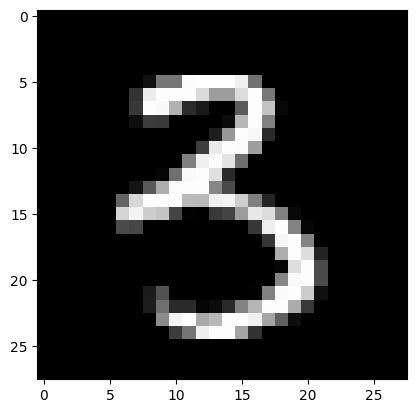

In [62]:
plt.imshow(img.reshape(28,28), cmap='gray')

In [63]:
outputs = model_loaded(img)

In [64]:
outputs

tensor([[-17.8146,  -4.6483,  -5.0312,  10.7081,  -9.7970,  -5.2426, -28.8252,
         -11.8818,  -4.0511,  -1.6052]], grad_fn=<AddmmBackward0>)

In [65]:
_, predict = torch.max(outputs, 1)

In [66]:
predict

tensor([3])